# Playground

The goal of this project is to generate medical reports from X-ray images. 
The Open-I X-ray image dataset with the corresponding medical reports will be used. The images are in grayscale. We will work on a few so-called *image2text* models. Previous work has explored using RNN with a co-attention mechanism. We'll primarily be exploring transformer models. In self-attention there is no need to extract "tags" as was the case for co-attention. Thus, the model has a larger degree of freedom to learn meaningful representations.

In [113]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [114]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models import vgg19, vit_b_16, ViT_B_16_Weights
from torchvision.transforms import Normalize

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

import spacy
#!python -m spacy download en_core_web_lg

import stanza

from utils import *
from dataset import *
from plots import *
from models import *
from nlp import *

fix_seed()

stanza.download("en")

08:42:28 - INFO: Downloading default packages for language: en (English) ...
08:42:30 - INFO: File exists: C:\Users\rasmu\stanza_resources\en\default.zip
08:42:34 - INFO: Finished downloading models and saved to C:\Users\rasmu\stanza_resources.


## Load data

Let's load the metadata and the images.

In [115]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [120]:
metadata = load_metadata(REPORT_PATH)
metadata.describe()

08:43:27 - INFO: found 3955 reports.


,patient_id
count,7470.000000
mean,1982.730388
std,1143.190929
min,0.000000
25%,994.000000
50%,1988.500000
75%,2969.750000
max,3954.000000


In [121]:
metadata

,patient_id,image_name,comparison,indication,findings,impression
0,0,CXR1_1_IM-0001-3001.png,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,0,CXR1_1_IM-0001-4001.png,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,1,CXR10_IM-0002-1001.png,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
3,1,CXR10_IM-0002-2001.png,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
4,2,CXR100_IM-0002-1001.png,None.,None,Both lungs are clear and expanded. Heart and m...,No active disease.
...,...,...,...,...,...,...
7465,3953,CXR998_IM-2479-1001.png,None.,XXXX-year-old XXXX with pain.,Cardiomediastinal silhouette demonstrates norm...,No acute cardiopulmonary abnormality.
7466,3953,CXR998_IM-2479-2001.png,None.,XXXX-year-old XXXX with pain.,Cardiomediastinal silhouette demonstrates norm...,No acute cardiopulmonary abnormality.
7467,3954,CXR999_IM-2480-1001.png,None,Chest pain,Lungs are clear bilaterally. There is no focal...,No acute cardiopulmonary abnormality.
7468,3954,CXR999_IM-2480-2001.png,None,Chest pain,Lungs are clear bilaterally. There is no focal...,No acute cardiopulmonary abnormality.


In [122]:
metadata = shuffle_metadata(metadata)

Notice, some of the text is censored by replacing words with "XXXX".

The feature "findings" describes the radiologists observations. While "impression" is the final diagnosis / conclusion.
Let's define a report as the concatation of the findings and impression text.

In [119]:
reports = prepare_reports(metadata)
reports.head()

08:43:11 - INFO: raw report length: 7470
08:43:11 - INFO: post-processing report length: 7430


0    The lungs are clear. There is no pleural effus...
1    The lungs are clear. There is no pleural effus...
2    The left and right XXXX remain enlarged and un...
3    Heart size and mediastinal contours are within...
4    Heart size and mediastinal contours are within...
Name: report, dtype: object

In [6]:
reports.describe()

count                                                  7430
unique                                                 3066
top       The heart is normal in size. The mediastinum i...
freq                                                     96
Name: report, dtype: object

Let's load the images. The images have been cropped such that the width and height are the same. Afterwards, the images have been downscaled to 256x256. 

In [7]:
# we'll only use a subset of the dataset in the *notebook* due to memory constraints. However, the scripts will use the full dataset.
N = 100
offset = 0 # use an offset so all these images correspond to the test dataset using by the trained model

metadata_subset = metadata[offset:offset+N]
reports_subset = prepare_reports(metadata_subset)

images = load_images(metadata_subset, IMAGE_PATH, resized=(224, 224))

12:42:42 - INFO: raw report length: 100
12:42:42 - INFO: post-processing report length: 100


There are images from two views: frontal and lateral. It may be worth to include this information in the model. However, since the view hasn't already been annotated, we will ignore it for now.

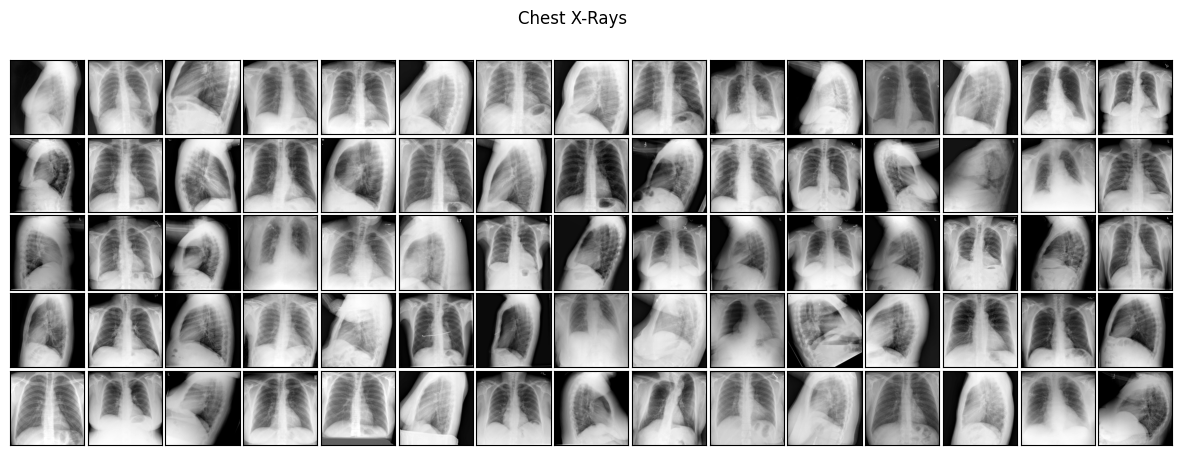

In [8]:
offset = 0
n_rows = 5
n_cols = 15

images_tiny = images[offset:offset+n_rows*n_cols]

plot_images_2d(images_tiny.reshape(n_rows, n_cols, *images_tiny.shape[1:]), "Chest X-Rays")

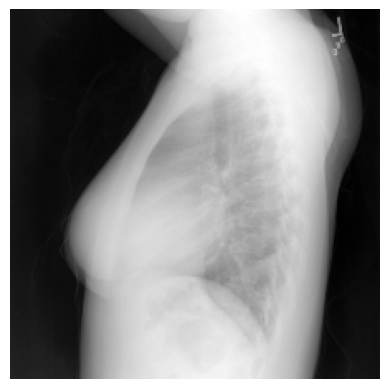

In [9]:
highlighted_image = images[0]
plot_image(highlighted_image)

Time to plot a few random X-ray image and their corresponding reports!

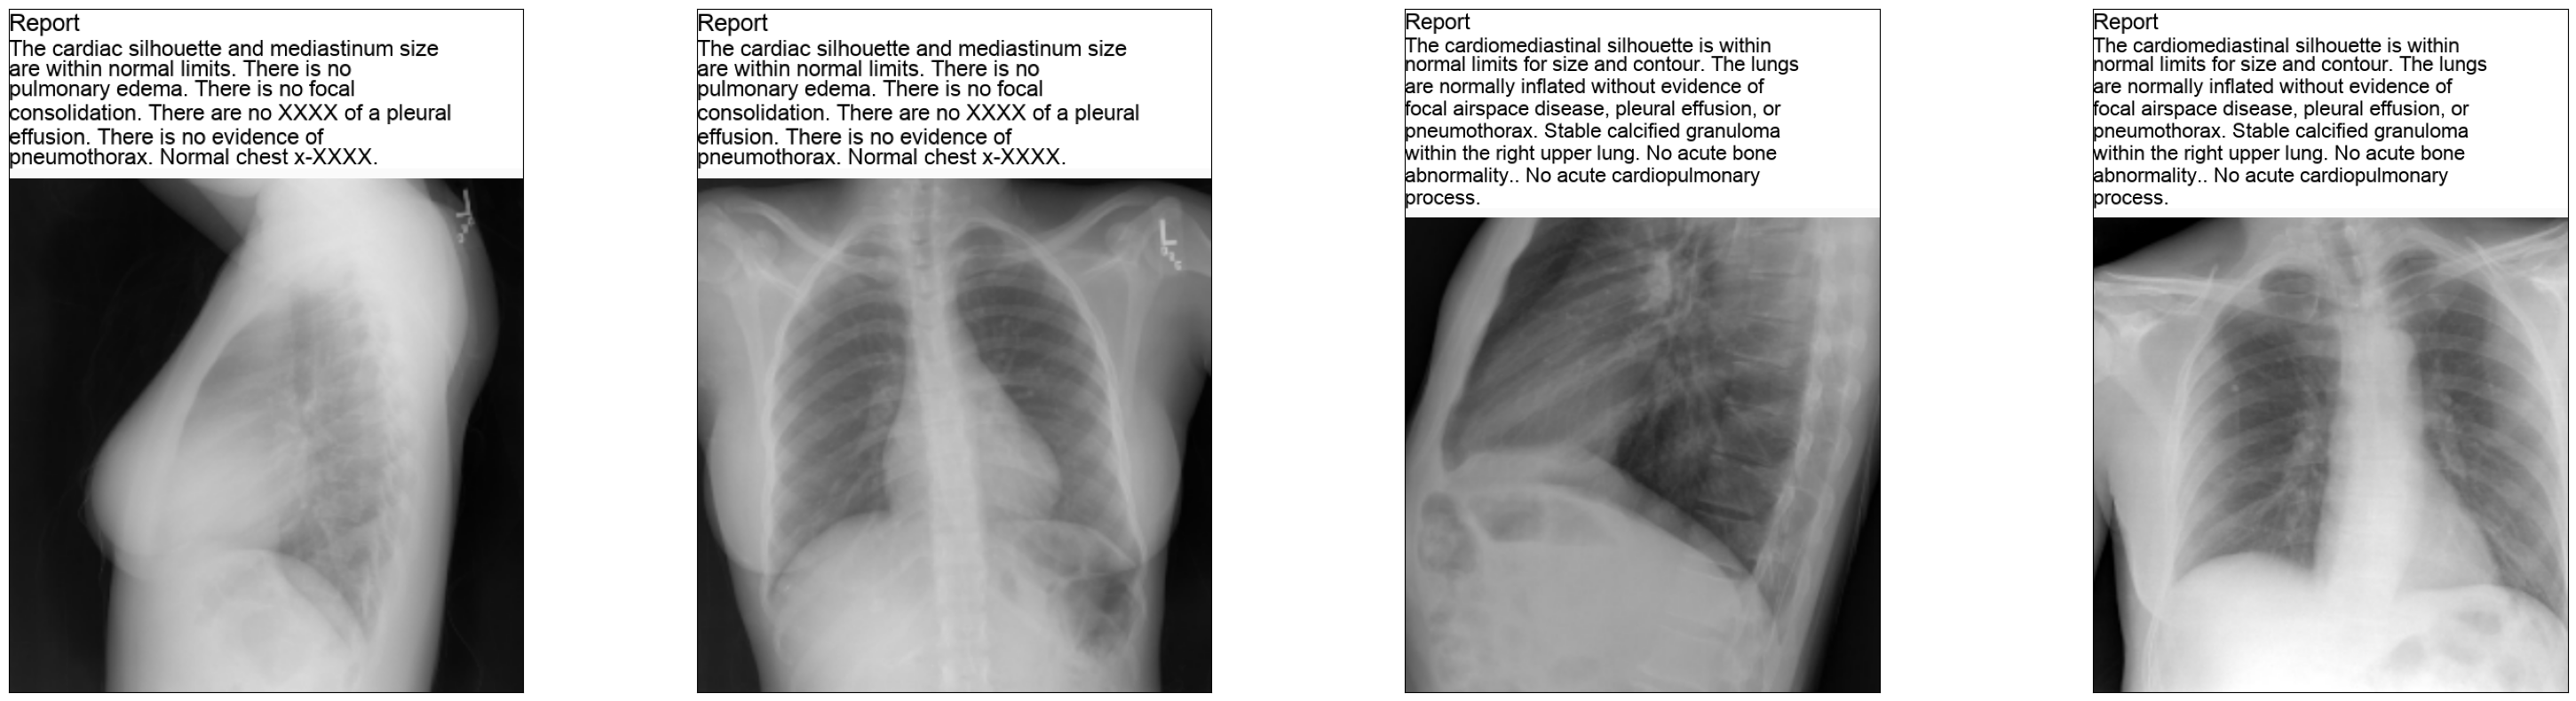

In [10]:
k = np.arange(4) #1400

title = "Report"
extracted_textbodies = reports.iloc[k]
extracted_images = images[k].numpy()

plot_multiple_text_and_images(extracted_textbodies, title, extracted_images)

## Preprocessing

### Images

Images are already normalized the range [0, 1]. The models may also do some more prepocessing of the images as some of them are pretrained model. Preprocessing includes z-score normalization. 

### Text

Let's tokenize the reports.

In [11]:
#tokenizer = spacy_tokenizer()
tokenizer = stanza_tokenizer()

tokenized_reports = reports.apply(lambda text : tokenize(text, tokenizer))

12:42:47 - INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
12:42:48 - INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

12:42:48 - INFO: Using device: cpu
12:42:48 - INFO: Loading: tokenize
12:42:48 - INFO: Done loading processors!


And time for some statistics:

In [12]:
tokenized_reports.head()

0    [the, cardiac, silhouette, and, mediastinum, s...
1    [the, cardiac, silhouette, and, mediastinum, s...
2    [the, cardiomediastinal, silhouette, is, withi...
3    [the, cardiomediastinal, silhouette, is, withi...
4    [both, lungs, are, clear, and, expanded, ., he...
Name: report, dtype: object

In [13]:
tokenized_reports_lengths = tokenized_reports.apply(len)

print(f"Report length: {np.mean(tokenized_reports_lengths):.1f} +- {np.std(tokenized_reports_lengths):.1f} words.")
print(f"Report length boundaries: [{np.min(tokenized_reports_lengths):.1f}; {np.max(tokenized_reports_lengths):.1f}] words.")

Report length: 42.5 +- 21.0 words.
Report length boundaries: [3.0; 248.0] words.


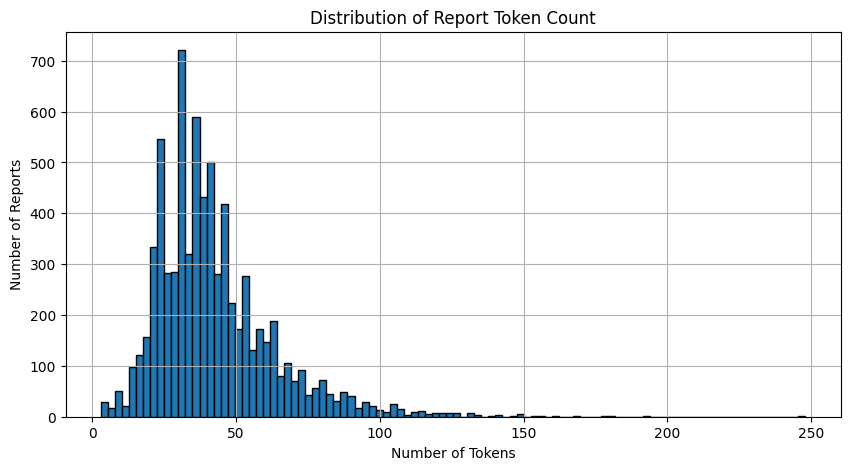

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(tokenized_reports_lengths, bins=100, histtype="bar", ec="black")
ax.set_title("Distribution of Report Token Count")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Number of Reports")
ax.grid()
plt.show()

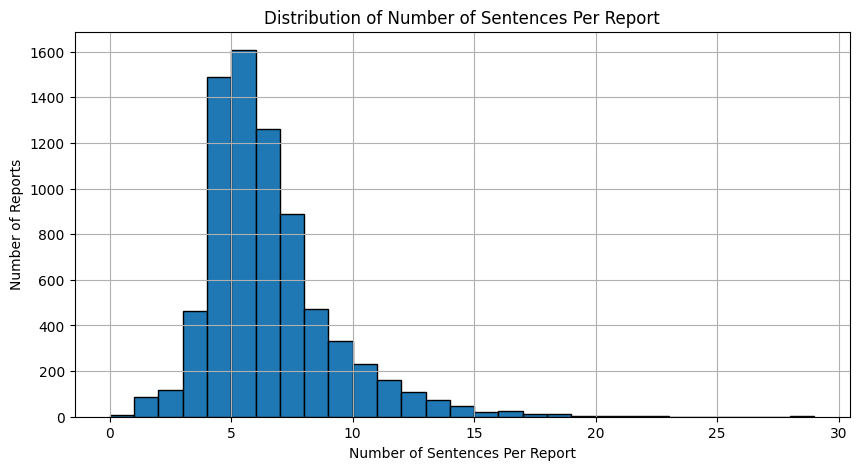

In [15]:
sentences = []
for token_ids in tokenized_reports:
    n_sentences = np.sum([1 for token in token_ids if token == "."])
    sentences.append(n_sentences)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sentences, bins=max(sentences), histtype="bar", ec="black")
ax.set_title("Distribution of Number of Sentences Per Report")
ax.set_xlabel("Number of Sentences Per Report")
ax.set_ylabel("Number of Reports")
ax.grid()
plt.show()

In [16]:
print(f"Number of sentences: {np.mean(sentences):.1f} +- {np.std(sentences):.1f} sentences.")
print(f"Number of sentences boundaries: [{np.min(sentences):.1f}; {np.max(sentences):.1f}] sentences.")

Number of sentences: 6.0 +- 2.6 sentences.
Number of sentences boundaries: [0.0; 29.0] sentences.


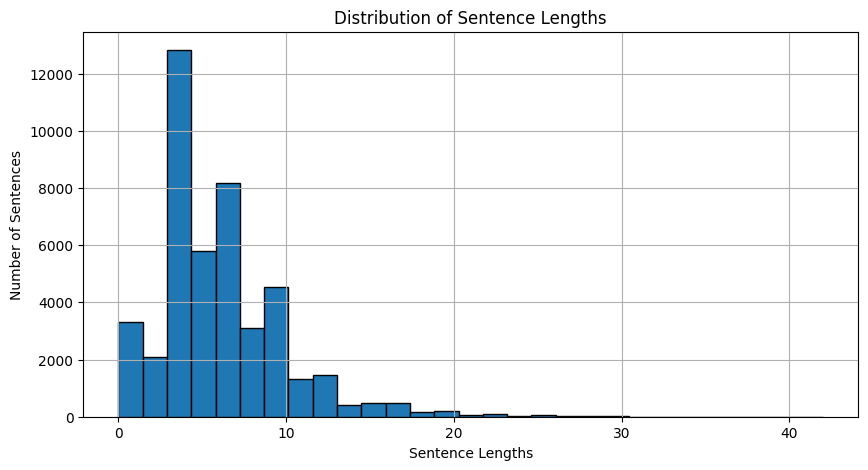

In [17]:
sentence_lengths = []
for token_ids in tokenized_reports:
    sentence_length = 0
    for token in token_ids:
        if token == ".":
            sentence_lengths.append(sentence_length)
            sentence_length = 0
        else:
            sentence_length += 1


fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sentence_lengths, bins=max(sentences), histtype="bar", ec="black")
ax.set_title("Distribution of Sentence Lengths")
ax.set_xlabel("Sentence Lengths")
ax.set_ylabel("Number of Sentences")
ax.grid()
plt.show()

Let's look at the most common words in the reports.

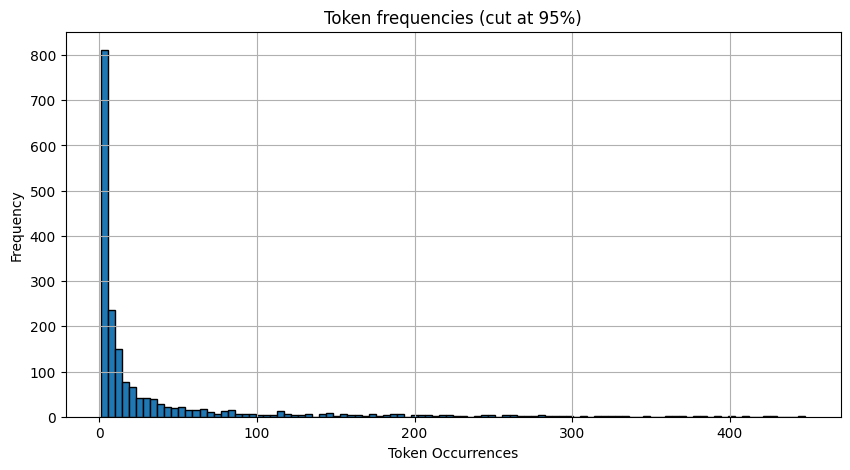

In [18]:
token_counts = count_token_occurences(tokenized_reports)

token_frequencies = [token_counts[token_id] for token_id in token_counts]
token_frequencies.sort(reverse=True)

cut_percent = 0.95
cut = (int)(len(token_frequencies)*(1-cut_percent))
token_frequencies = token_frequencies[cut:]
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(token_frequencies, bins=100, histtype="bar", ec="black")
ax.set_title(f"Token frequencies (cut at {cut_percent*100:.0f}%)")
ax.set_xlabel("Token Occurrences")
ax.set_ylabel("Frequency")
ax.grid()
plt.show()

Our dataset is small, and since most of the words are very infrequent, we will be using pre-trained embeddings.

Let's see the most frequent tokens:

In [19]:
token_ids = [token_id for token_id in token_counts]
token_ids.sort(key=lambda token_id : token_counts[token_id], reverse=True)

N = 20

for token in token_ids[:N]:
    print(f"{token} ({token_counts[token]})")

. (44679)
no (14553)
the (13438)
is (8946)
are (8761)
normal (7720)
of (6426)
and (6412)
acute (5818)
pleural (5430)
or (5427)
pneumothorax (4896)
effusion (4793)
there (4744)
heart (4732)
lungs (4528)
size (4304)
focal (3663)
clear (3608)
pulmonary (3237)


and the size of the vocabulary...

In [20]:
vocabulary = build_vocabulary([token for tokens in tokenized_reports for token in tokens])
print(f"vocabulary size: {len(vocabulary)} tokens")

token2id, id2token = map_token_and_id(vocabulary)

vocabulary size: 1932 tokens


## Models

Time for training...

In [21]:
vectors, embed_dim = load_pubmed_embeddings_IU_xray_pretrained()
#vectors, embed_dim = load_bundled_glove_embeddings()
word_embeddings = prepare_word_embeddings(token2id, vectors, embed_dim)

unknown_tokens_embeddings = [token for token in vocabulary if token not in vectors]
print(f"Number of tokens not in word embeddings: {len(unknown_tokens_embeddings)}")

Number of tokens not in word embeddings: 5


In [22]:
unknown_tokens_embeddings[:5]

['nlarged', '<PAD>', '.', 'v', 'mergent']

In [96]:
"""
model_name = "playground"
model = XRayPlaygroundModel(len(vocabulary))


model_name = "chex2"
model = CheXTransformerNet(word_embeddings)


model_name = "chex1"
model = CheXNet1(word_embeddings)

"""

model_name = "vit"
model = XRayViTModel(word_embeddings)


images_ready = model.preprocess(images)

train_test_split = .9
train_validation_split = .9

size = len(images)
size = 10

total_train_size = int(size * train_test_split)
train_size = int(total_train_size * train_validation_split)
train_end = size+1

train_dataset = XRayDataset(images_ready[:train_size], tokenized_reports[:train_size], token2id)
validation_dataset = XRayDataset(images_ready[train_size:total_train_size], tokenized_reports[train_size:total_train_size], token2id)
test_dataset = XRayDataset(images_ready[total_train_size:train_end], tokenized_reports[total_train_size:train_end], token2id)

In [ ]:
train(model_name, model, vocabulary, train_dataset, validation_dataset, epochs=20, batch_size=16, optimizer=optim.Adam(model.parameters(), lr=0.001), disable_tqdm=False)

Actually, the model is already trained. Let's load the weights and evalulate the performance.

In [26]:
result = load_dict(os.path.join("results", model_name, "train_result.pkl"))

train_losses = result["train_losses"]
validation_losses = result["validation_losses"]
validation_bleus = result["validation_bleu"]

train_loss = train_losses[-1]
validation_loss = validation_losses[-1]

accuracy = lambda loss: np.exp(-loss)
perplexity = lambda loss: np.exp(loss)

loss_random = -np.log(1 / len(vocabulary))

tokens_counts_np = np.array(list(token_counts.values()))
loss_base = -np.log(tokens_counts_np.max() / tokens_counts_np.sum())

print(f"loss | train: {train_loss:.3f}, validation: {validation_loss:.3f}, random: {loss_random:.3f}, base: {loss_base:.3f}")
print(f"perplexity | train: {perplexity(train_loss):.3f}, validation: {perplexity(validation_loss):.3f}, random: {perplexity(loss_random):.3f}, base: {perplexity(loss_base):.3f}")
print(f"accuracy | train: {accuracy(train_loss):.4f}, validation: {accuracy(validation_loss):.4f}, random: {accuracy(loss_random):.4f}, base: {accuracy(loss_base):.4f}")

for i, bleu in enumerate(validation_bleus):
    p = [f"{x:.3f}" for x in bleu]
    print(f"epoch {i * len(train_losses) // len(validation_bleus):3} | validation bleus: {p}")

loss | train: 3.964, validation: 4.032, random: 7.566, base: 1.956
perplexity | train: 52.661, validation: 56.360, random: 1932.000, base: 7.069
accuracy | train: 0.0190, validation: 0.0177, random: 0.0005, base: 0.1415
epoch   0 | validation bleus: ['0.005', '0.000', '0.000', '0.000']
epoch   5 | validation bleus: ['0.051', '0.023', '0.000', '0.000']
epoch  10 | validation bleus: ['0.051', '0.023', '0.000', '0.000']
epoch  15 | validation bleus: ['0.051', '0.023', '0.000', '0.000']


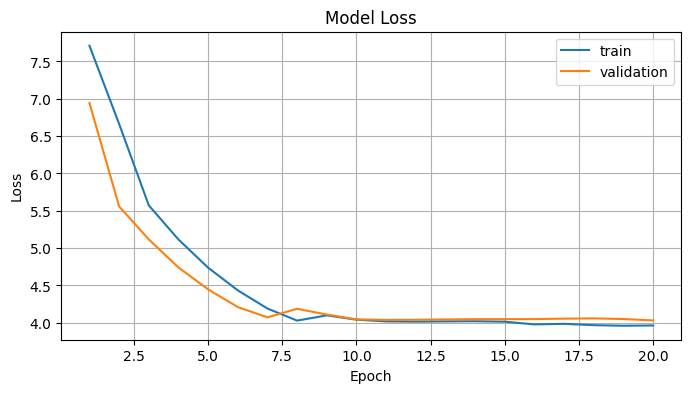

In [27]:
plot_losses(train_losses, validation_losses)

## Evaluation

Time to generate some reports!

In [40]:
model.load_state_dict(torch.load(os.path.join("models", model_name, "model_200.pt"), map_location=torch.device("cpu")))

<All keys matched successfully>

true:  <START> the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no of a pleural effusion. there is no evidence of pneumothorax. normal chest. <END>
guess: <START> cardiac and mediastinal contours are within normal limits. pulmonary vascularity is within normal limits. there is no focal consolidation pneumothorax or large pleural effusion identified. there are no acute bony abnormalities. no acute cardiopulmonary abnormalities. <END>


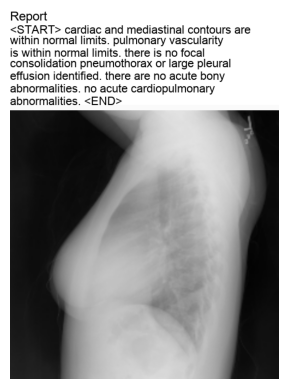

In [41]:
sample_idx = 0
x, report_ids, _ = train_dataset[sample_idx]

target = [id2token[token] for token in report_ids]

generated_ids = prob_sample(model, x, token2id, max_length=100)
generated = [id2token[token] for token in generated_ids]

report = tokens_to_text(target)
report_est = tokens_to_text(generated)

print(f"true:  {report}")
print(f"guess: {report_est}")

xray_plotable = images[sample_idx].numpy()
plot_text_and_image(report_est, "Report", xray_plotable)

In [42]:
beams = beam_search(model, x, token2id, beam_width=1, max_length=75)

for beam in beams:
    print(tokens_to_text([id2token[id] for id in beam[1]]))

<START> cardiac and mediastinal contours are within normal limits. pulmonary vascularity is within normal limits. there is no focal consolidation pneumothorax or large pleural effusion identified. there are mild degenerative changes of the thoracic spine. no acute bony abnormalities. <END>


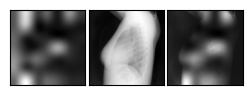

In [46]:
_, = model(torch.tensor(report_ids)[None], x[None])

attn_context_token = model.decoder.decoder_layer1.multihead_attn_weights
attn_context = attn_context_token.squeeze(0).mean(dim=0)

image_attention_mask = create_image_attention_mask(attn_context.detach().numpy(), xray_plotable.shape, (7, 7), interpolation=cv2.INTER_CUBIC)
plot_images(np.array([image_attention_mask, xray_plotable, image_attention_mask * xray_plotable]))

In [54]:
def overlay_attention(image, attention_mask, alpha=0.45):
    normalized_attn = image_attention_mask / image_attention_mask.max()
    xray_plotable_3 = np.stack([xray_plotable] * 3, axis=2)
    xray_plotable_3[:,:,0] = xray_plotable_3[:,:,0] * (1 - alpha) + normalized_attn * alpha * 0
    xray_plotable_3[:,:,1] = xray_plotable_3[:,:,1] * (1 - alpha) + normalized_attn * alpha
    xray_plotable_3[:,:,2] = xray_plotable_3[:,:,2] * (1 - alpha) + normalized_attn * alpha * 0
    return xray_plotable_3

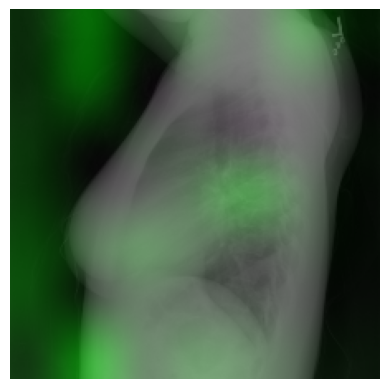

In [55]:
img1 = overlay_attention(xray_plotable, image_attention_mask)
plot_image_multichannel(img1)

Let's explore where the transformer model puts it attention on the image. 

In [ ]:
# @TODO: don't use the avg attention between all n heads?

N_words = 20
_, = model(torch.tensor(report_ids)[None], x[None])
attention_weights_tokens = model.decoder.decoder_layer1.mha_weights[0][:N_words].detach().numpy()

image_attentions = np.empty((attention_weights_tokens.shape[0], 3, 224, 224))
for i, attention_weights in enumerate(attention_weights_tokens):
    image_attention_mask = create_avg_image_attention_mask(attention_weights_tokens[:,1:], xray_plotable.shape, (14, 14))
    image_attentions[i] = np.array([image_attention_mask, xray_plotable, image_attention_mask * xray_plotable])

plot_images_2d(image_attentions.transpose(1,0,2,3))

In [66]:
bleu = compute_bleu(model, test_dataset, token2id, id2token, max_length=200)

03:24:38 - INFO: passing sample 0/2
c:\Users\rasmu\anaconda3\envs\xray\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\rasmu\anaconda3\envs\xray\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [67]:
bleu

[0.10344827586206899,
 0.03673316399837258,
 3.369474432385502e-103,
 2.858915930086776e-155]

In [35]:
references, candidates = prepare_for_evaluation(model, train_dataset, token2id, id2token, early_exit=10)
            
# get some feedback during training
for i in range(len(references)):
    example_truth = references[i][0]
    example_prediction = candidates[i]

    logging.info("True and predicted report:")
    logging.info(f"true: {tokens_to_text(example_truth)}")
    logging.info(f"pred: {tokens_to_text(example_prediction)}")
    logging.info("")

12:57:09 - INFO: passing sample 0/8
c:\Users\rasmu\anaconda3\envs\xray\Lib\site-packages\torch\nn\modules\activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ..\aten\src\ATen\native\transformers\attention.cpp:152.)
  return torch._native_multi_head_attention(
12:58:00 - INFO: True and predicted report:
12:58:00 - INFO: true: the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no of a pleural effusion. there is no evidence of pneumothorax. normal chest.
12:58:00 - INFO: pred: ap chest examination ap ap ap ap scoliosis frontal ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap ap scoliosis scoliosis scoliosis scoliosis scoliosis scoliosis scoliosis scoliosis scoliosis scoliosis. some discrete suture destructive suture destructive sut

## Misc

In [70]:
model = CheXTransformerNet(word_embeddings)
model.load_state_dict(torch.load(os.path.join("models", model_name, "model.pt"), map_location=torch.device("cpu")))

<All keys matched successfully>

In [71]:
input = torch.tensor(report_ids)[:30][None]

In [72]:
tokens_to_text([id2token[id] for id in report_ids])

'[START] the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no of a pleural effusion. there is no evidence of pneumothorax. normal chest. [END]'

In [73]:
with torch.no_grad():
    model.eval()
    out = model(input, x[None])
    out.shape

In [74]:
token_ids = out.argmax(dim=-1)
token_ids.shape

torch.Size([1, 30])

In [75]:
token_ids = [id2token[id.item()] for id in token_ids[0]]
tokens_to_text(token_ids)

'the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no of a pleural effusion'

In [29]:
from gensim.models import Word2Vec

In [30]:
model= Word2Vec.load("embeddings/imonban_vectorsRandomForest.model")

In [33]:
model.wv.vectors.shape

(4442, 730)

In [ ]:
['artifactually',
 'biapical',
 'malalignment',
 'epipericardial',
 'intrathoracic']

In [87]:

def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [137]:
import gensim

In [88]:
embeddings = load_glove_model("embeddings/custom.300d.txt")

Loading Glove Model
54854 words loaded!


In [54]:
model.wv.key_to_index["hemorrhage"]

12

# Check